# Binary Classification of 747 vs A380
The goal is to classify a picture between two classes : an Boing 747 or an Airbus A380

There is a nice script to get images from Google : https://github.com/boxabirds/fastai-helpers/blob/master/training-data-generator.py, it's based on https://github.com/hardikvasa/google-images-download wich use ChromeDriver to automate the process.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
PATH = "../../datasets/boing_vs_airbus/"
#PATH = "../../datasets/A380_vs_A330/"

In [3]:
## Getting dataset
#!mkdir ../../datasets/boing_vs_airbus
#!pip install google_images_download
#!ls ../../datasets/
#!cd {PATH} && mkdir -p train/747 train/A380 test/747 test/A380  valid/747 valid/A380
#!cd {PATH}/747 && googleimagesdownload --keywords "Boing 747" --limit 1000 --chromedriver /usr/local/bin/chromedriver
#!cd {PATH}/A380 && googleimagesdownload --keywords "Airbus A380" --limit 1000 --chromedriver /usr/local/bin/chromedriver
## Getting models weights
#!cd ./fastai && wget http://files.fast.ai/models/weights.tgz && tar -xvzf weights.tgz
!ls {PATH}

downloads  models  tmp	train  valid


In [4]:
print("Setting CUDA devices...")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"
print("Loading Fast.AI modules...")
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *


sz=299
arch=resnet34
#arch=resnext50
bs=132

Setting CUDA devices...
Loading Fast.AI modules...


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
print("CuDNN optimization is ", torch.backends.cudnn.enabled)

CuDNN optimization is  True


Data augmentation options : https://becominghuman.ai/data-augmentation-using-fastai-aefa88ca03f1

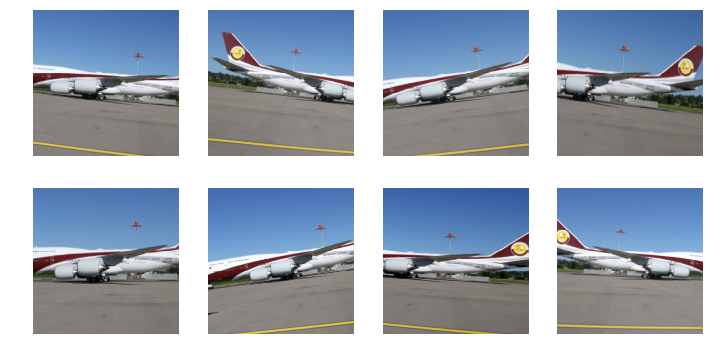

In [6]:

aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),
        RandomFlip(),
        RandomLighting(0.05, 0.05,tfm_y=TfmType.NO),
        RandomZoom(zoom_max=0.2),
        RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
# Taille de batch faible pour trouver le bon learning rate
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())

def get_augs():
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=2, num_workers=2)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(8)])
plots(ims, rows=2)

In [7]:
#next(iter(data.aug_dl)) Retourne batch_size images de taille sz*sz
len(data.trn_ds.fnames)
# data.trn_ds contient le dataset de test
data.trn_ds.fnames[100]

size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

1388

'train/747/48. delta-boeing-747.jpg'

/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Combien avons nous d'échantillons dans notre base d'entrainement

(array([659.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 729.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

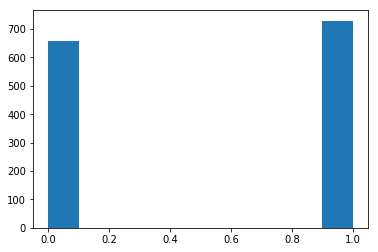

In [8]:
plt.hist(data.trn_y)

Environs 500 images pour les deux classes, c'est équilibré.
Regardons maintenant la taille des images.

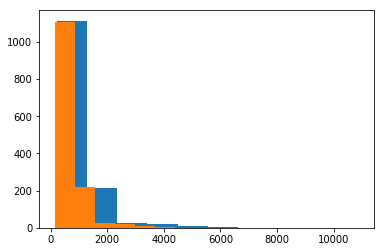

In [9]:
plt.hist(row_sz);
plt.hist(col_sz);

Il y a beaucoup de petites images, zoomons sur le graph pour être sûr qu'elle ne sont pas trop petites

(array([ 24.,  57.,  51.,  79., 123., 197.,  84., 109.,  36.,  64.]),
 array([220. , 297.2, 374.4, 451.6, 528.8, 606. , 683.2, 760.4, 837.6, 914.8, 992. ]),
 <a list of 10 Patch objects>)

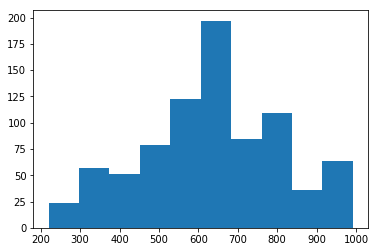

In [10]:
plt.hist(row_sz[row_sz < 1000])

C'est bon, les plus petites font plus de 200 pixels.
On note que la majorité on une taille importante, il sera bon de faire des entrainement du modèle avec des tailles supérieures.

_"How many images should we use as a validation set? [01:26:28] Using 20% is fine unless the dataset is small — then 20% is not enough. If you train the same model multiple times and you are getting very different validation set results, then your validation set is too small. If the validation set is smaller than a thousand, it is hard to interpret how well you are doing. If you care about the third decimal place of accuracy and you only have a thousand things in your validation set, a single image changes the accuracy. If you care about the difference between 0.01 and 0.02, you want that to represent 10 or 20 rows. Normally 20% seems to work fine."_
=> Nous avons environs 100 images de validation par classes, ça devrait donc aller.

Faisons un test d'entrainement avec une petite taille de batch pour estimer la valeur du learning rate.

In [11]:

learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)
lrf=learn.lr_find()

100%|██████████| 57/57 [00:02<00:00, 19.00it/s]


 48%|████▊     | 84/174 [00:01<00:01, 49.49it/s, loss=0.856]


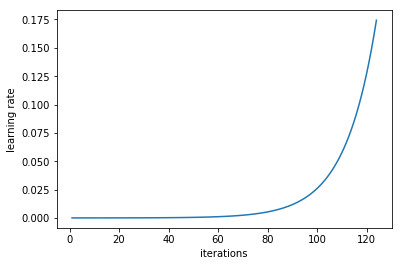

In [12]:
learn.sched.plot_lr()

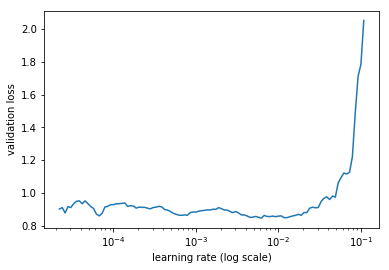

In [13]:
learn.sched.plot()

1e-2 semble une bonne valeur

In [14]:
loadmodel=False
#loadmodel=True
if loadmodel==True:
    tfms = tfms_from_model(resnet34, 300, aug_tfms=aug_tfms, max_zoom=0.5)
    # On recharge les données avec une taille de batch plus importante pour aller plus vite
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    learn.precompute=False
    learn.ps=dropout # Drop-out plus faible pour les premières couches pour éviter de désapprendre des choses.
    learn.load("resnet34_151_300_weights")
    print("Model chargé")

In [15]:
learning_rate = 1e-3
dropout = [0.25,0.5]
global_results = collections.OrderedDict([])

training_loop = [
    [512, 64, 4],
    [256, 128, 3],
    [123, 300, 3],
    [64, 600, 3],
    [123, 300, 6],
    [256, 128, 2],
    [123, 300, 2],
    [64, 600, 3],
    [123, 400, 2]
]
for bs, sz, cycle in training_loop:
    print("Hyperparameters : Batch size=", bs, " Drop out=", dropout, " Learning rate=", learning_rate, " Cycle=", cycle, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    # On recharge les données avec une taille de batch plus importante pour aller plus vite
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    learn.precompute=False
    learn.ps=dropout # Drop-out plus faible pour les premières couches pour éviter de désapprendre des choses.
    
    lr=np.array([learning_rate/10,learning_rate/5,learning_rate]) # Learning rate plus faible pour les premières couche, pour ré-apprendre un peu si necessaire
    learn.unfreeze()
    vals_s2s, ep_vals_s2s = learn.fit(lr, cycle, cycle_len=1, cycle_mult=2, get_ep_vals=True)
    if len(global_results) > 0:
        #print(global_results)
        for k, v in ep_vals_s2s.items():
            global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)

Hyperparameters : Batch size= 512  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 4  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.750805   0.67147    0.594655  
    1      0.621517   0.538766   0.746102                    
    2      0.589478   0.541886   0.717149                    
    3      0.540585   0.444477   0.786192                    
    4      0.471054   0.415614   0.806236                    
    5      0.39127    0.40084    0.817372                    
    6      0.403932   0.394109   0.819599                    
    7      0.329257   0.334543   0.861915                    
    8      0.343521   0.343791   0.841871                    
    9      0.292913   0.32009    0.855234                    
    10     0.301639   0.304021   0.855234                    
    11     0.261357   0.30824    0.861915                    
    12     0.239198   0.277151   0.86637                     
    13     0.236799   0.292306   0.873051                    
    14     0.210081   0.287642   0.86637                     

After  15  epochs, the ac

epoch      trn_loss   val_loss   accuracy                    
    0      0.284274   0.276503   0.873051  
    1      0.250727   0.253323   0.888641                    
    2      0.237063   0.270135   0.886414                    
    3      0.171373   0.265388   0.873051                    
    4      0.215994   0.275296   0.875278                    
    5      0.218699   0.2652     0.88196                     
    6      0.155006   0.276741   0.875278                    

After  22  epochs, the accuracy is  87.52 %
Saving to  resnet34_22_128_acc87.52_weights
Hyperparameters : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 3  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.188128   0.253133   0.893096  
    1      0.208402   0.26259    0.899777                    
    2      0.19197    0.238911   0.904232                    
    3      0.191948   0.255711   0.899777                    
    4      0.17436    0.246541   0.899777                    
    5      0.166617   0.236946   0.89755                     
    6      0.15535    0.285292   0.875278                    

After  29  epochs, the accuracy is  87.52 %
Saving to  resnet34_29_300_acc87.52_weights
Hyperparameters : Batch size= 64  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 3  Images sizes= 600


epoch      trn_loss   val_loss   accuracy                    
    0      0.163791   0.289523   0.886414  
    1      0.175249   0.229385   0.902004                    
    2      0.127259   0.218607   0.908686                    
    3      0.16255    0.214786   0.91314                     
    4      0.138436   0.248414   0.902004                    
    5      0.121323   0.219444   0.917595                    
    6      0.1561     0.220061   0.915367                    

After  36  epochs, the accuracy is  91.53 %
Saving to  resnet34_36_600_acc91.53_weights
Hyperparameters : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 6  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.144743   0.21984    0.91314   
    1      0.134812   0.256776   0.906459                    
    2      0.144323   0.281672   0.908686                    
    3      0.134735   0.210011   0.908686                    
    4      0.184187   0.261835   0.899777                    
    5      0.141155   0.211796   0.926503                    
    6      0.155853   0.211126   0.924276                    
    7      0.121518   0.246749   0.906459                    
    8      0.154023   0.222511   0.915367                    
    9      0.172026   0.292773   0.893096                    
    10     0.146189   0.258217   0.893096                    
    11     0.127768   0.267413   0.893096                    
    12     0.153922   0.254916   0.899777                    
    13     0.149745   0.21399    0.910913                    
    14     0.092704   0.219344   0.917595                     
    15     0.112319   0.2

epoch      trn_loss   val_loss   accuracy                     
    0      0.085801   0.149895   0.942094  
    1      0.073273   0.165243   0.928731                     
    2      0.061556   0.159822   0.930958                     
    3      0.071063   0.174964   0.922049                     
    4      0.070928   0.178643   0.922049                     
    5      0.048771   0.165492   0.924276                     
    6      0.059941   0.159705   0.930958                     

After  106  epochs, the accuracy is  93.09 %
Saving to  resnet34_106_128_acc93.09_weights
Hyperparameters : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 3  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                     
    0      0.069215   0.165162   0.933185  
    1      0.048597   0.16739    0.935412                     
    2      0.101403   0.168543   0.930958                     
    3      0.091422   0.179183   0.928731                     
    4      0.072299   0.166738   0.937639                     
    5      0.082013   0.147911   0.937639                     
    6      0.0773     0.160802   0.928731                     

After  113  epochs, the accuracy is  92.87 %
Saving to  resnet34_113_300_acc92.87_weights
Hyperparameters : Batch size= 64  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 3  Images sizes= 600


epoch      trn_loss   val_loss   accuracy                     
    0      0.057762   0.163677   0.935412  
    1      0.06915    0.175998   0.930958                     
    2      0.096057   0.154357   0.935412                     
    3      0.083265   0.150755   0.939866                     
    4      0.081781   0.166163   0.939866                     
    5      0.057126   0.156205   0.928731                     
    6      0.074229   0.156222   0.935412                     

After  120  epochs, the accuracy is  93.54 %
Saving to  resnet34_120_600_acc93.54_weights
Hyperparameters : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 5  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                     
    0      0.102836   0.172364   0.928731  
    1      0.061945   0.189597   0.922049                     
    2      0.079301   0.189313   0.924276                     
    3      0.071444   0.180476   0.930958                     
    4      0.091513   0.160744   0.933185                     
    5      0.084758   0.177069   0.937639                     
    6      0.091861   0.158497   0.930958                     
    7      0.063484   0.162403   0.933185                     
    8      0.046854   0.146841   0.942094                     
    9      0.059105   0.151558   0.935412                     
    10     0.085647   0.14005    0.937639                     
    11     0.050739   0.138644   0.939866                     
    12     0.08141    0.168202   0.928731                     
    13     0.071337   0.139632   0.944321                     
    14     0.067428   0.13959    0.937639                     
    15     

SGDR : Earlier we said 3 is the number of epochs, but it is actually *cycles*. So if cycle_len=2 , it will do 3 cycles where each cycle is 2 epochs (i.e. 6 epochs). Then why did it 7? It is because of cycle_mult :
    cycle_mult=2 : this multiplies the length of the cycle after each cycle (1 epoch + 2 epochs + 4 epochs = 7 epochs).

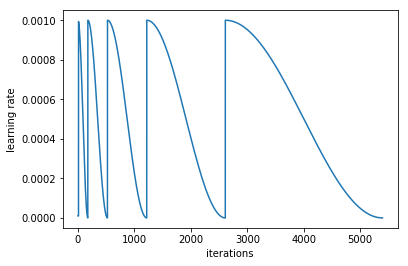

In [16]:
learn.sched.plot_lr()

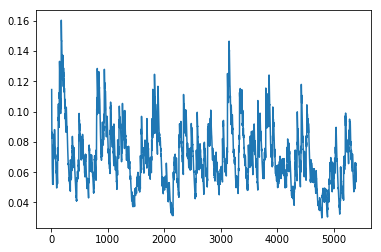

In [17]:
learn.sched.plot_loss()

In [18]:
# Il faudrait recalculer le LR optimal mais la taille de batch est trop grande, le graph reste vide.
#lrf=learn.lr_find()
#learn.sched.plot()
# ep_vals_s2s

In [19]:
len(learn.sched.losses)
#ep_vals_s2s.values()
print("Nombre d'epochs : ", len(global_results))

5394

Nombre d'epochs :  151


<Figure size 800x640 with 0 Axes>

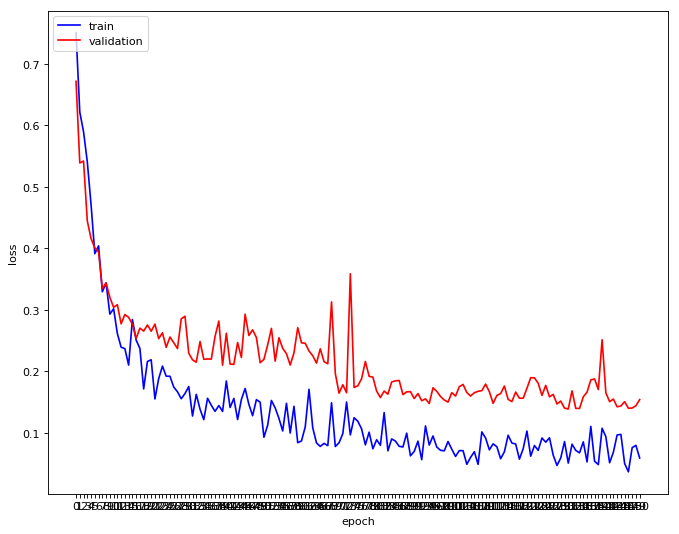

In [20]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = len(ep_vals)#ep_vals.keys()
    #plt.xticks(np.asarray(list(epochs)))
    plt.xticks((list(ep_vals)))
    #print((list(ep_vals)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    #print(trn_losses)
    val_losses = [item[1] for item in list(ep_vals.values())]
    #print(val_losses)
    plt.plot(list(ep_vals), trn_losses, c='b', label='train')
    plt.plot(list(ep_vals), val_losses, c='r', label='validation')
    plt.legend(loc='upper left')
plot_ep_vals(global_results)

# Prediction et visualisation

0.9532293986636972

[[144  16]
 [  5 284]]


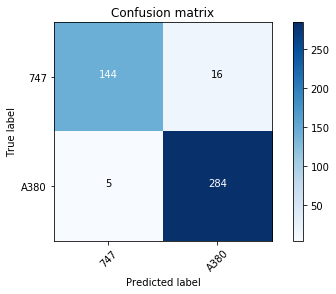

In [21]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

## Precision and Recall
Précision et rappel en français : https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel
_La précision est le nombre de documents pertinents retrouvés rapporté au nombre de documents total proposé par le moteur de recherche pour une requête donnée. _ Autrement dit quelle proportion d'identifications positives était effectivement correcte ?

_Le rappel est défini par le nombre de documents pertinents retrouvés au regard du nombre de documents pertinents que possède la base de données._ Autrement dit quelle proportion de résultats positifs réels a été identifiée correctement ?

In [22]:
# precission = VP / (VP + FP)
precision = cm[0][0]/(cm[0][1]+cm[0][0]);
print("Precision : ", precision)
# recall =  = VP / (VP + FN)
recall = cm[0][0]/(cm[1][0]+cm[0][0]);
print("recall : ", recall)
F1 = 2 * ((precision*recall)/(precision + recall))
print("F1 : ", F1)
F2 = 5 * ((precision*recall)/(4*precision + recall))
print("F2 : ", F2)

Precision :  0.9
recall :  0.9664429530201343
F1 :  0.9320388349514563
F2 :  0.9523809523809523


(array([160.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 289.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

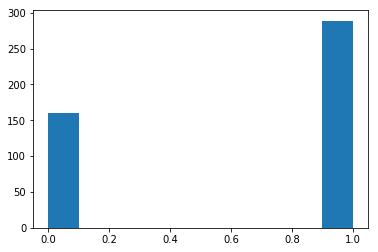

In [23]:
# This is the label for a val data
plt.hist(data.val_y)

In [24]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['747', 'A380']

In [25]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape  # = (nombre de prediction , nombre de classe)

(449, 2)

In [26]:
#log_preds[:10]

In [27]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [28]:
# Récupère aléatoirement des prédictions
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 15), replace=False)

# Récupère les prédictions correctes
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

# Affiche les images
def plots(ims, figsize=(20,10), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i])

# Charge l'image
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

# Affiche des images avec un titre
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [(str(probs[x]) + "\n" + str(data.val_ds.fnames[x][10:][:20])) for x in idxs]
    print(title)
    return plots(imgs, rows=5, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

# Recupère les prédiction triées
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:15]] # Les 32 premiers éléments

# Recupère les prédictions les plus justes
def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most incorrect 747


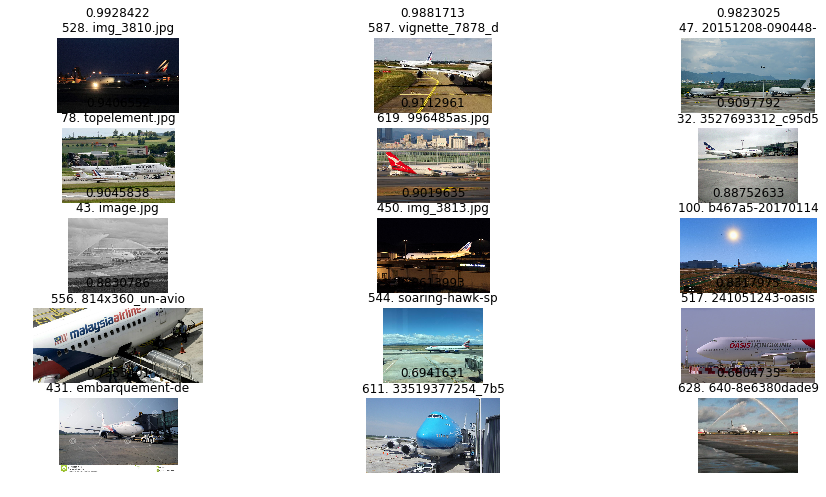

In [29]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect " + data.classes[0])

Most incorrect A380


ValueError: num must be 1 <= num <= 5, not 6

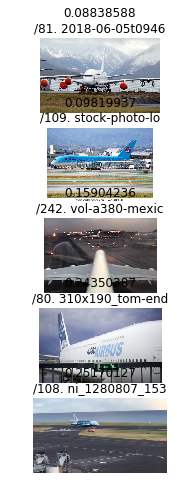

In [30]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect " + data.classes[1])

Most uncertain predictions


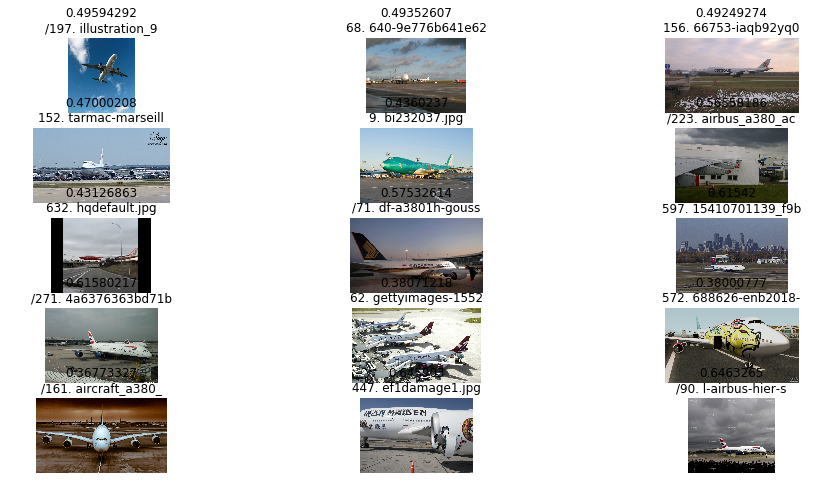

In [34]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:15]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

Most correct A380


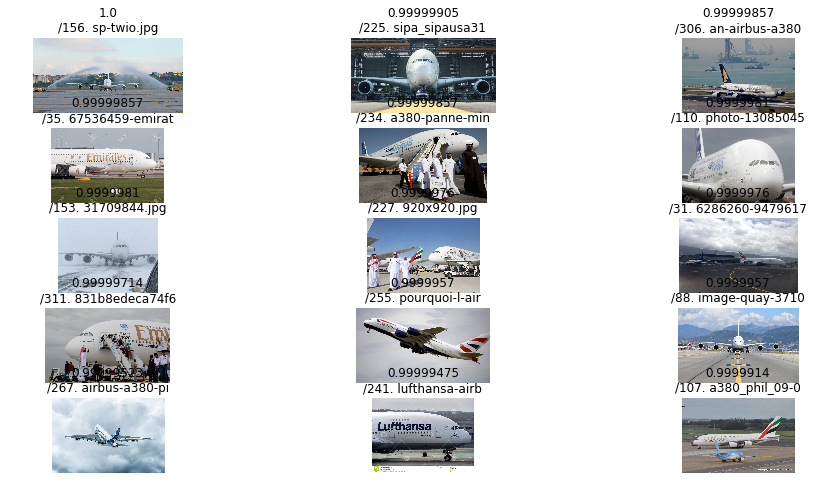

In [32]:
plot_val_with_title(most_by_correct(1, True), "Most correct " + data.classes[1])

Most correct 747


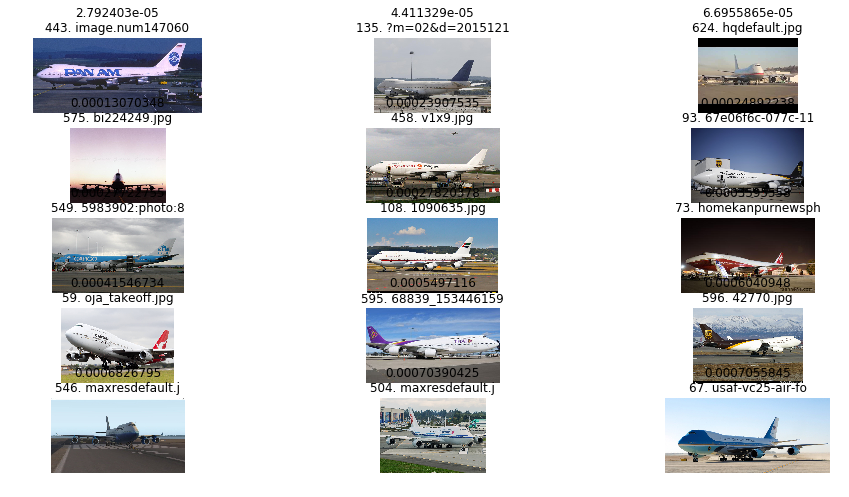

In [33]:
plot_val_with_title(most_by_correct(0, True), "Most correct " + data.classes[0])
# 1. A few correct labels at random
#plot_val_with_title(rand_by_correct(True), "Correctly classified")
# 2. A few incorrect labels at random
#plot_val_with_title(rand_by_correct(False), "Incorrectly classified")